Introduction
    The objective of this mini lab is to build and evaluate two classifciation models to predict a student's placement status based on various academic, techincal, and personal attributes. The dataset, Student Placement, is hosted on Kaggle and contains features such as CGPA, communication skills, coding skills, certification, and backlog count.
    The two supervised learning algorithms used for this lab were Logistic Regression and Support Vector Machines (SVM). Logistic Regression models primarly serves as baseline due to its simplicity and effectiveness on lineary seperable data. Whereas, SVM models have a higher ability to handle linear and non-linear decision boundaries. 
    The lab follows a sturctured machine learning workflow, which includes data preprocessing, feature enginerring, model traning, evaluation using an 80/20 train-test split, and tuning the paramters to improve model performance. Model performance is assessed using accuracy and confusion matrices to understand classification behaviors across classes. Additionally, feature importance analysis is used to determine whether reducing the feature set improves performance and interpretablitiy. 


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics as mt

In [5]:
#loading dataset

df = pd.read_csv("/Users/muskaanmahes/Downloads/full_dataset.csv")
print(df.shape)
df.head()             

(50000, 15)


,Student_ID,Age,Gender,Degree,Branch,CGPA,Internships,Projects,Coding_Skills,Communication_Skills,Aptitude_Test_Score,Soft_Skills_Rating,Certifications,Backlogs,Placement_Status
0,1048,22,Female,B.Tech,ECE,6.29,0,3,4,6,51,5,1,3,Not Placed
1,37820,20,Female,BCA,ECE,6.05,1,4,6,8,59,8,2,1,Not Placed
2,49668,22,Male,MCA,ME,7.22,1,4,6,6,58,6,2,2,Not Placed
3,19467,22,Male,MCA,ME,7.78,2,4,6,6,90,4,2,0,Placed
4,23094,20,Female,B.Tech,ME,7.63,1,4,6,5,79,6,2,0,Placed


Data Preprocessing and Feature Engineering
    Before trainig the models, several preprocessing steps were applied to prepare the dataset for classification. Firstly, the attribute, Student_ID, was removed as its only purpose is to serve as a unique indentifier and it does not provide any predicitive value for determining placement status. Secondly, missing values were handled using a group-based imputation strategy which grouped Degree and Branch, under the assumption that students enrolled in the same academic program share similar charactersitics. Additionally, numerical feature were imputed using the median in each group to reduce the influence of outleirs, while categorical features were imputed usimg the group mode to preserve the most frequent occuring category in each group. 
    After imputation, the numerical and categorical features were recombined into a single dataset, and the grouped values were restored to ensure consistency. Additionally, a new variable called cgpa_range was created by discretizing the continuous CGPA variable in ordinal bins to allow the model to capture non-linear relationships bewteen academic performance and placement outcomes. Lastly, any remaining observations which contained missing values were removed to ensure that the final dataset was complete and ready for feature encoding and model training. 

In [9]:
#dropping ID 
df.drop(columns = ["Student_ID"], errors= 'ignore')

#identifying numeric and categorical columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(include=['object']).columns

#impute numeric columns using group median 
df_imputed = df.copy()

for col in numeric_columns:
    df_imputed[col] = (
        df.groupby(['Degree', 'Branch'])[col]
        .transform(lambda x: x.fillna(x.median()))
    )

# impute categorical columns using group mode
for col in categorical_columns:
    df_imputed[col] = (
        df.groupby(['Degree', 'Branch'])[col]
        .transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
    )

# Create CGPA  with the newest values
df_imputed['cgpa_range'] = pd.cut(
    df_imputed['CGPA'],
    bins=[0, 5.5, 7.0, 8.5, 10.01],
    labels=[0, 1, 2, 3],
    include_lowest=True
)

df_imputed['cgpa_range'] = df_imputed['cgpa_range'].astype(int)


#drop rows with missing values
df_imputed = df_imputed.dropna(subset=['Placement_Status'])




    

Train-Test Split and Feature Encoding
    Within this section, categorical variables were converted into numerical values using one-hot encoding to ensure it is compatiable with machine learning algorithms. Therefore, the variables Gender, Degree, and Branch were encoded using the dummy variables, and the first category was also dropped to avoid multicollinearity. Then the dataset was seperated into feature matrix X, which contains all the predictor variables, and target variable y which represented the placement stautus.
    To evaluate the model performance, and 80/20 train-test split was implemented using the ShuffleSplit cross-validation method. This method randomly shuffles and split the data into the training and testing sets three seperate times, with 20% of the data saved for testing in each iteration. The printed output confirms that the configuration of the cross validation object, and displays that the multiple randomized train-test splits were generated. 

In [10]:
#train/test split

#performing one hot encoding on categorical data
df_encoded = pd.get_dummies(df_imputed, columns=['Gender', 'Degree', 'Branch'], drop_first=True)
                                          
#predict the X and y data
y = df_encoded['Placement_Status'].values
X = df_encoded.drop(columns=['Placement_Status']).values

#CV 
cv_object = ShuffleSplit(n_splits =3, test_size = 0.2, random_state=14)

print(cv_object)



ShuffleSplit(n_splits=3, random_state=14, test_size=0.2, train_size=None)


Logistic Regression with All Features
    A logisitc regression model was trained with all features in the dataset to establish a baseline classification performance. The model was created using the logistic regression function wih an L2 regularization strenght of C=1.0, and the liblinear solver. Additionally, all features were standarized to have a mean of zero and a unit variance, which is crucial for logistic regression to ensure that features measured on different scales contribute equally to the model. 
    The model evaluation was performed using ShuffleSplit cross validation stragey, which resulted in three 80/20 train-test splits. Therefore, these three iterations achieved accuracy values of 86.8%, 87.4%, and 86.7%. This indicated stable performances across the different random splits of data. Additionally, the confusion matrices showed that each model classified a large proportion of both placed and not-placed studnets with more false negatives than false positives. Therefore, overall, these results demonstrated that the logistic regression performs realiably on datasets using all features. 

In [11]:
# logistic regression with all features

#creating logistic regression object with diff learning paramaters and constants
lr_clf = LogisticRegression(C=1.0, class_weight=None, solver= 'liblinear')


#training loop 
iter_num=0
for train_idx, test_idx in cv_object.split(X,y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


    #standarizing features to have mean = 0 & sd =1
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #train the lr model on the training data
    lr_clf.fit(X_train_scaled, y_train)
    y_hat = lr_clf.predict(X_test_scaled)

    #evaluate
    accuracy = mt.accuracy_score(y_test, y_hat)
    conf = mt.confusion_matrix(y_test, y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", accuracy )
    print("confusion matrix\n",conf)
    iter_num+=1

    
                            

====Iteration 0  ====
accuracy 0.8678
confusion matrix
 [[5770  611]
 [ 711 2908]]
====Iteration 1  ====
accuracy 0.8735
confusion matrix
 [[5804  612]
 [ 653 2931]]
====Iteration 2  ====
accuracy 0.8663
confusion matrix
 [[5691  649]
 [ 688 2972]]


Logistic Regression with Important Features
    In this section, logistic regression model was applied to a reduced set of features identified as most important in the previous lab, and its performance was compared to that of the full-feature model. These features included communication skills, backlog count, CGPA, coding skills, number of projects, certifications, and aptitude test score. The dataset which included these predictors and placement status was split into training and testing sets using an 80/20 ShuffleSplit strategy to maintain consistency with earlier experiments. 
    All features were again standarized, and logistic regression classifier with L2 regularization along with the liblinear solver was trained on the reduced set. The result achieved an accuracy of 86.7%, which is almost identical to the previous model trained on all features. 
    Below, the confusion matrix indicates that the model correctly classified a large proportion of both placed and not-placed students, in a similar baseline of false positives and false negatives as the full logistic regression model did. Therefore, these results show that the reduced feature set preserves most of the predicitive power of the full dataset while improving model simplicity and interpretability. 

df_top shape: (50000, 8)
Logistic Regression Accuracy (important features): 0.8673


/opt/anaconda3/envs/DS7331/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


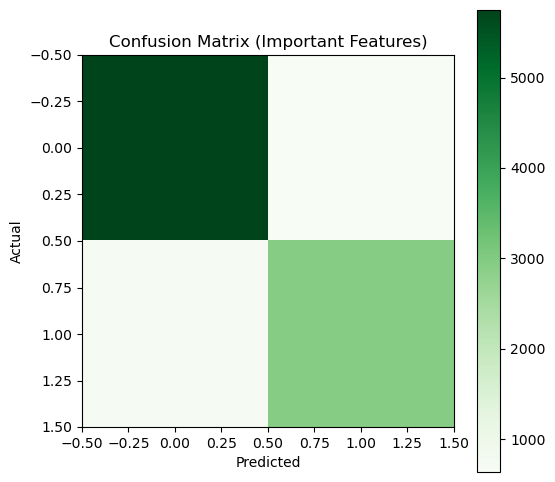

In [13]:
import matplotlib.pyplot as plt
#running the logisitic regression with the chosen/important features
# top features chosen from last lab

top_features = [
    'Communication_Skills',
    'Backlogs',
    'CGPA',
    'Coding_Skills',
    'Projects',
    'Certifications',
    'Aptitude_Test_Score'
]

#check
df_top = df_encoded[top_features + ['Placement_Status']]
print("df_top shape:", df_top.shape)

# split the features and labels
X = df_top.drop(columns=['Placement_Status']).values
y = df_top['Placement_Status'].values

# 3. CV
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# 4. Logistic Regression model 
lr_clf = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',  # or 'lbfgs' if you prefer
    max_iter=1000
)

#Train/test loop
scaler = StandardScaler()


for train_idx, test_idx in cv.split(X, y):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    # Standardize features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    lr_clf.fit(X_train_scaled, y_train)

    # Predict
    y_hat = lr_clf.predict(X_test_scaled)

    # Evaluate
    acc = mt.accuracy_score(y_test, y_hat)
    conf = mt.confusion_matrix(y_test, y_hat)


print(f"Logistic Regression Accuracy (important features): {acc:.4f}")

plt.figure(figsize=(6, 6))
plt.imshow(conf, cmap='Greens')
plt.title("Confusion Matrix (Important Features)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Logistic Regression using Stochastic Gradient Descent
    To explore different ways of model performance, logistic regression was implemented using the stochastic gradient descent with the SGDClassifier. Doing so is more appropriate for larger datasets because it updates the parmeters incrementally. Therefore, the model was configured with L2 regularization to control overfitting, an optimal learning rate schedule, and a regularization constant was used to balance variance and bias. Before training, all features were standarized to ensure efficient gradient updates. Additionally, an 80/20 train-test split was performed using the shuffle-based cross-validation strategy.
    The resulting model achieved an accuracy of 63.5% which is lower than what was obtained using the standard logistic regression solver. Additionally, the confusion matrix indicated the gradient descent model heavily favored predicting the negative class, which led to a larger number of misclassified positive instances. Therefore, this suggest that gradient descent based logistic regression is computationally efficient, but it may require more careful tuning of hyperparamters, regularization strength, or number of iterations to achieve performance comparable to the baseline model of this dataset. 

Logistic Regression: 0.6345


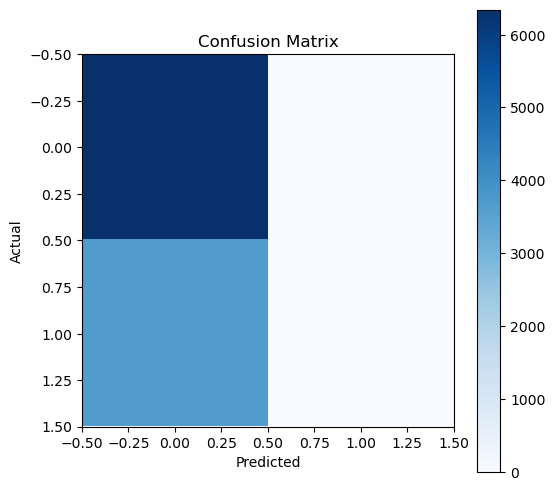

In [14]:
#running the logisitc regression with gradient descent

from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.linear_model import SGDClassifier



#setup
regularize_const = 0.0001
iterations = 150
cv = ShuffleSplit(n_splits = 1, test_size=0.2, random_state =3)
 
log_sgd = SGDClassifier(
    alpha=regularize_const,
    fit_intercept=True,
    l1_ratio=0.0,
    learning_rate='optimal',
    loss='log_loss',
    n_iter_no_change=iterations,
    n_jobs=-1,
    penalty='l2'

)

scl = StandardScaler()

#traing loop
for train_idx, test_idx in cv.split(X, y):
    log_sgd.fit(X_train_scaled, y[train_idx])
    X_train_scaled = scl.fit_transform(X[train_idx])
    X_test_scaled = scl.transform(X[test_idx])
    
    yhat = log_sgd.predict(X_test_scaled)

    conf = mt.confusion_matrix(y[test_idx], yhat)
    acc = mt.accuracy_score(y[test_idx], yhat)
print('Logistic Regression:', acc)

#plot cm
plt.figure(figsize=(6, 6))
plt.imshow(conf, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

    

Support Vector Machine with Important Features
A Support Vector Machine classifier was trained next using the same selection of important features indentified earlier in the analysis to evaluate whether a non-linear model could improve classification performance. A 80/20 train-test split was performed using a shuffle-based cross validation strategy, and all the features were standardized before training. Additionally, the model was implemented using the radial basis function (RBF) kernel with a regularization parameter C = 0.5 and automatic gamma selection, allowing the classifier to learn non-linear decision boundaries. 
    The resulting SVM achieved an accuracy of 99.2% which significantly outperformed both logistic regression models. Additionally, the confusion matrix had very few misclassifications, with only a small number of false positives and false negatives, indicating strong performance across both classes. Overall, these results demonstrated that the SVM model captures complex relationship more effectively than logistic regression. 

In [15]:
#SVM 
from sklearn.svm import SVC

#defining the top featues based on importance 
top_features = [
    'Communication_Skills',
    'Backlogs',
    'CGPA',
    'Coding_Skills',
    'Projects',
    'Certifications',
    'Aptitude_Test_Score'
]

df_top = df_encoded[top_features + ['Placement_Status']]

#define new x and y
y = df_top['Placement_Status'].values
X = df_top.drop(columns=['Placement_Status']).values

# CV
cv_object = ShuffleSplit(n_splits=1, test_size=0.2, random_state=3)

#fit the model
for train_idx, test_idx in cv_object.split(X, y):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


#training SVM model
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto')
svm_clf.fit(X_train_scaled, y_train)

#predict
y_hat = svm_clf.predict(X_test_scaled)

#Evaluate
accuracy = mt.accuracy_score(y_test, y_hat)
conf = mt.confusion_matrix(y_test, y_hat)

print('accuracy:', accuracy )
print(conf)

#look at support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )



accuracy: 0.9923
[[6307   38]
 [  39 3616]]
(2602, 7)
(2602,)
[1304 1298]


Support Vector Machine with Linear Kernel
    Next a Support Vector Machine with a linear kernel was trained using the same subset of important features to evaluate whether a simple linear decision boundary is sufficient for the classifcation task. The linear SVM was configured with an 80/20 shuffle-based cross-validation strategy, and a regularization parameter of C = 0.5. The resulting model achieved an accuracy of 87.3% which is comparable to the performance of logistic regression models, but it is still lower than than the non-linear SVM with an RBF kernel. 
    The confusion matrix shows a balanced distribution of false positives and false negatives. Additionally, the large number of support vectors suggest that many data points lie close to the decision boundary, which indicates that the relationshop between the features and target variable is not strictly linear. Therefore, these results indicated that a non-linear kernel is better suited for capturing complex patterns present in the dataset. 

In [100]:
#svm with linear kernel

#defining the top featues based on importance 
top_features = [
    'Communication_Skills',
    'Backlogs',
    'CGPA',
    'Coding_Skills',
    'Projects',
    'Certifications',
    'Aptitude_Test_Score'
]

df_top = df_encoded[top_features + ['Placement_Status']]

#define new x and y
y = df_top['Placement_Status'].values
X = df_top.drop(columns=['Placement_Status']).values

# CV
cv_object = ShuffleSplit(n_splits=1, test_size=0.2, random_state=3)

#fit the model
for train_idx, test_idx in cv_object.split(X, y):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


#training SVM model
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto')
svm_clf.fit(X_train_scaled, y_train)

#predict
y_hat = svm_clf.predict(X_test_scaled)

#Evaluate3
accuracy = mt.accuracy_score(y_test, y_hat)
conf = mt.confusion_matrix(y_test, y_hat)

print('accuracy:', accuracy )
print(conf)

#look at support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )


accuracy: 0.873
[[5682  663]
 [ 607 3048]]
(13229, 7)
(13229,)
[6614 6615]


Model Selection and Final Recommendation
    Several classification models were evaluated for predicting student placement stauts, including logistic regression and support vector machines with both linear and non-linear kernels. The logistic regression models performed consistently and provided interpretable results, while the SVM achieved a similar accuracy, indicating that some linear structure does exist in the data. However, the SVM with an RBF kernel outperformed all other models as it achieved the highest accuracy, and had the fewest misclassifications. This indicates that the relationship between student attributes and placement outcomes is non-linear. Therefore, based on these results, the RBF SVM is the perferred model for this task due to its high predicitive performance. 
